In [2]:
# imports and loading
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
from pymodulon.io import *
from matplotlib_venn import venn3
from pymodulon.enrichment import *

TRN_df = pd.read_csv('../data/external/TRN.csv', index_col = 0)
ica_data = load_json_model('../data/interim/zmo_raw.json.gz')


/home/chris/miniforge3/envs/iM_miner/lib/python3.10/site-packages/pymodulon/util.py:31: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table = pd.read_json(table)
/home/chris/miniforge3/envs/iM_miner/lib/python3.10/site-packages/pymodulon/util.py:31: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table = pd.read_json(table)
/home/chris/miniforge3/envs/iM_miner/lib/python3.10/site-packages/pymodulon/util.py:31: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table = pd.read_json(table)
/home/chris/miniforge3/envs/iM_miner/lib/python3.10/site-packages/pymodulon/util.py:31: FutureWarning: Passing literal json to 'read_json' 

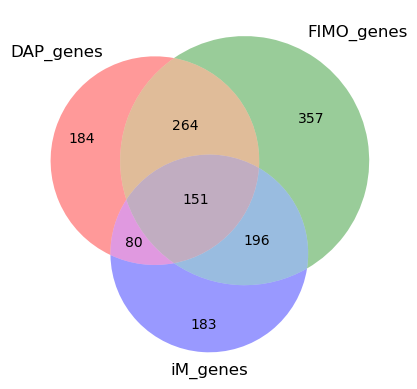

In [3]:
all_genes = set(ica_data.gene_table.index)
DAP_genes = set(TRN_df.gene_id)
df = ica_data.gene_table.fillna(0)
iM_genes = set(df[df['iMs'] != 0].index)
df = ica_data.gene_table
FIMO_genes = set(df[[len(val) > 2 for val in ica_data.gene_table['FIMO_regulators']]].index)


venn3([DAP_genes, FIMO_genes, iM_genes], ('DAP_genes', 'FIMO_genes', 'iM_genes'))
plt.savefig('../figures/venn3_overlap.pdf', transparent = True)
plt.show()

In [8]:
shared = list(DAP_genes.intersection(FIMO_genes).intersection(iM_genes))

In [17]:
a = ica_data.gene_table.loc[shared]['COG'].value_counts() / len(shared)

In [18]:
b = ica_data.gene_table['COG'].value_counts() / len(ica_data.gene_table.index)

In [20]:
(a - b).sort_values()

COG
Translation, ribosomal structure and biogenesis                     -0.063466
Amino acid transport and metabolism                                 -0.041333
Replication, recombination and repair                               -0.041308
Coenzyme transport and metabolism                                   -0.036406
Nucleotide transport and metabolism                                 -0.029870
Carbohydrate transport and metabolism                               -0.013357
Cell motility                                                       -0.011809
Cell cycle control, cell division, chromosome partitioning          -0.010807
Lipid transport and metabolism                                      -0.009544
Energy production and conversion                                    -0.002031
Defense mechanisms                                                   0.002438
Post-translational modification, protein turnover, and chaperones    0.003243
Cell wall/membrane/envelope biogenesis                      

In [56]:
df = ica_data.gene_table
results = []
for COG in a.index:
    target = df[df['COG'] == COG].index.to_list()
    gene_set = list(shared)
    res = compute_enrichment(gene_set, target, df.index)
    results.append(res)
res_df = pd.DataFrame(results)
res_df['COG'] = a.index
res_df = res_df[['COG', 'pvalue', 'precision', 'recall', 'f1score', 'TP', 'target_set_size', 'gene_set_size']]

In [57]:
res_df.sort_values(by = 'pvalue')

,COG,pvalue,precision,recall,f1score,TP,target_set_size,gene_set_size
1,No COG annotation,0.000023,0.218543,0.167513,0.189655,33.0,197.0,151.0
2,Inorganic ion transport and metabolism,0.000679,0.099338,0.202703,0.133333,15.0,74.0,151.0
6,Signal transduction mechanisms,0.040941,0.046358,0.175000,0.073298,7.0,40.0,151.0
0,Function unknown,0.052731,0.225166,0.106918,0.144989,34.0,318.0,151.0
3,Transcription,0.089502,0.079470,0.125000,0.097166,12.0,96.0,151.0
4,Cell wall/membrane/envelope biogenesis,0.432144,0.072848,0.089431,0.080292,11.0,123.0,151.0
8,"Post-translational modification, protein turno...",0.478006,0.039735,0.089552,0.055046,6.0,67.0,151.0
9,Defense mechanisms,0.497540,0.019868,0.093750,0.032787,3.0,32.0,151.0
5,Energy production and conversion,0.601356,0.052980,0.079208,0.063492,8.0,101.0,151.0
11,Lipid transport and metabolism,0.835798,0.019868,0.055556,0.029268,3.0,54.0,151.0


In [29]:
a.index

Index(['Function unknown', 'No COG annotation',
       'Inorganic ion transport and metabolism', 'Transcription',
       'Cell wall/membrane/envelope biogenesis',
       'Energy production and conversion', 'Signal transduction mechanisms',
       'Amino acid transport and metabolism',
       'Post-translational modification, protein turnover, and chaperones',
       'Defense mechanisms', 'Translation, ribosomal structure and biogenesis',
       'Lipid transport and metabolism',
       'Carbohydrate transport and metabolism', 'Cell motility',
       'Nucleotide transport and metabolism',
       'Cell cycle control, cell division, chromosome partitioning',
       'Coenzyme transport and metabolism',
       'Replication, recombination and repair'],
      dtype='object', name='COG')